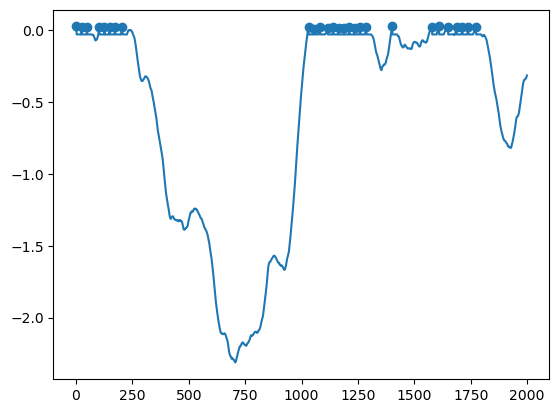

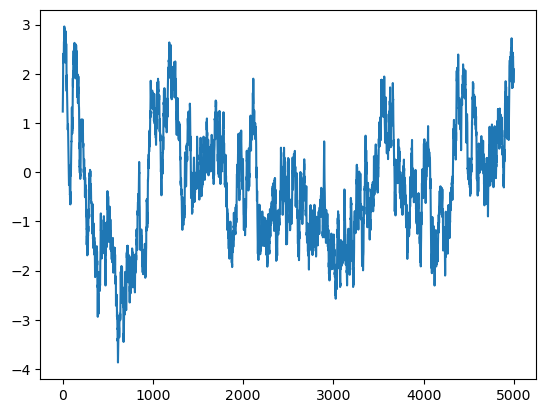

In [4]:
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt
from brian2 import TimedArray, ms

def OU_test(mu, dt, tau, sigma, unit, total_t):
    np.random.seed(0)
    time = np.arange(0, total_t, dt)
    x = np.zeros((len(time), 1))
    x[0, 0] = 1
    for i in range(1, len(time)):
        x[i, 0] = mu + ((x[i - 1, 0] - mu) * np.exp(-dt / tau)) + sigma * np.sqrt(
            1 - np.exp(-2 * dt / tau)
        ) * np.random.normal()
    curr = TimedArray(x * unit, dt=dt * ms)
    return curr

default_pars = {
    'V_th': 0.0279, 'V_reset': -0.0279, 'tau_m': 10.0,
    'g_L': 1.0, 'V_init': 0, 'E_L': 0.0, 'tref': 2.0,
    'T': 500.0, 'dt': 0.1,
    'range_t': np.arange(2000), 'seed': 0
}

def run_LIF(pars, stop=False):
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_init, E_L = pars['V_init'], pars['E_L']
    dt, range_t = pars['dt'], pars['range_t']
    T = pars['T']
    seed = pars['seed']
    Lt = range_t.size
    tref = pars['tref']
    v = np.zeros(Lt)
    v[0] = V_init

    SNR = 0.6
    st = OU_test(0, dt, 10, 1, 1, T).values
    nt = OU_test(0, dt, 10, 1, 1, T).values
    Iinj = SNR * st + np.sqrt(1 - SNR) * nt
    rec_spikes = []
    tr = 0.

    for it in range(Lt - 1):
        if tr > 0:
            v[it] = V_reset
            tr = tr - 1

        elif v[it] >= V_th:
            rec_spikes.append(it)
            v[it] = V_reset
            tr = tref / dt

        dv = (-(v[it] - E_L) + Iinj[it] / g_L) * (dt / tau_m)
        v[it + 1] = v[it] + dv
        rec_spikes_ = np.array(rec_spikes) * dt

    return v, rec_spikes_, Iinj

spikes_t_s_u = []
spikes_t_s_r = []
N_stim = 100

for i in range(N_stim):
    default_pars['seed'] = i
    v, spikes, st = run_LIF(default_pars)
    spikes_t_s_u.append(spikes)

    default_pars['seed'] = 0
    v, spikes, nt = run_LIF(default_pars)
    spikes_t_s_r.append(spikes)

plt.plot(v)
plt.scatter(np.array(spikes / 0.1 - 0.01, dtype=np.int32), v[np.array(spikes / 0.1 - 0.01, dtype=np.int32)])
plt.show()
plt.plot(nt)
plt.show()
